In [2]:
import os
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = False


In [2]:
### Check for truncated images due to augmentation
def validate_images(image_directory):
    for filename in os.listdir(image_directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            try:
                with Image.open(os.path.join(image_directory, filename)) as img:
                    img.verify()
            except (IOError, SyntaxError) as e:
                print(f"Corrupted file detected: {filename}")

image_directory = '/home/chris/Documents/chagas/split_images/negative_images'
validate_images(image_directory)

In [ ]:
### Find mean and std of input images
transform = transforms.Compose([
    transforms.Resize((1632, 1224)),  
    transforms.ToTensor()            
])

dataset = datasets.ImageFolder(root='processed_whitebalance', transform=transform)
loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

def compute_mean_std(loader):
    mean = 0.
    squared_sum = 0.
    n_samples = 0.
    
    for data, _ in loader:
        data = data.view(data.size(0), data.size(1), -1)  
        n_samples += data.size(0)
        mean += data.mean(2).sum(0)
        squared_sum += (data ** 2).mean(2).sum(0)
    
    mean /= n_samples
    squared_sum /= n_samples
    std = (squared_sum - mean ** 2) ** 0.5
    return mean, std

mean, std = compute_mean_std(loader)
print('mean:', mean)
print('std Deviation:', std)

In [22]:
### Dataloader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

transform = transforms.Compose([
    transforms.Resize((1632, 1224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4406, 0.4091, 0.4566], std=[0.4132, 0.3935, 0.4148])
])

dataset = datasets.ImageFolder(
    root='processed_whitebalance',
    transform=transform
)

train_proportion = 0.6
val_proportion = 0.2


### Stratified split data
sss = StratifiedShuffleSplit(n_splits=1, test_size=1 - train_proportion, random_state=69)

targets = [target for _, target in dataset.samples]
indices = list(range(len(targets)))

for train_indices, non_train_indices in sss.split(indices, targets):
    pass

non_train_proportion = 1 - train_proportion
relative_val_size = val_proportion /non_train_proportion
sss_non_train = StratifiedShuffleSplit(n_splits=1, test_size=relative_val_size, random_state=69)

non_train_targets = [targets[i] for i in non_train_indices]
for val_indices, test_indices in sss_non_train.split(non_train_indices, non_train_targets):
    pass


val_indices = [non_train_indices[i] for i in val_indices]
test_indices = [non_train_indices[i] for i in test_indices]

stratified_train = Subset(dataset, train_indices)
stratified_val = Subset(dataset, val_indices)
stratified_test = Subset(dataset, test_indices)

train_loader = DataLoader(stratified_train, batch_size=16, shuffle=True)
val_loader = DataLoader(stratified_val, batch_size=16, shuffle=False)
test_loader = DataLoader(stratified_test, batch_size=16, shuffle=False)

### Network Architecture
class NeuralNetwork(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(NeuralNetwork, self).__init__()
        self.dropout_rate = dropout_rate

        # Block 1
        self.conv1_1 = nn.Conv2d(3, 16, kernel_size=10, stride=1, padding=1)
        self.bn1_1 = nn.BatchNorm2d(16)
        self.conv1_2 = nn.Conv2d(16, 16, kernel_size=10, stride=1, padding=1)
        self.bn1_2 = nn.BatchNorm2d(16)
        self.conv1_3 = nn.Conv2d(16, 16, kernel_size=10, stride=1, padding=1)
        self.bn1_3 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2,2)
        self.dropout1 = nn.Dropout(self.dropout_rate)
        
        # Block 2
        self.conv2_1 = nn.Conv2d(16, 32, kernel_size=10, stride=1, padding=1)
        self.bn2_1 = nn.BatchNorm2d(32)
        self.conv2_2 = nn.Conv2d(32, 32, kernel_size=10, stride=1, padding=1)
        self.bn2_2 = nn.BatchNorm2d(32)
        self.conv2_3 = nn.Conv2d(32, 32, kernel_size=10, stride=1, padding=1)
        self.bn2_3 = nn.BatchNorm2d(32)
        self.dropout2 = nn.Dropout(self.dropout_rate)
        self.pool2 = nn.MaxPool2d(2,2)     
        
        # Block 3
        self.conv3_1 = nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=1)
        self.bn3_1 = nn.BatchNorm2d(64)
        self.conv3_2 = nn.Conv2d(64, 64, kernel_size=7, stride=1, padding=1)
        self.bn3_2 = nn.BatchNorm2d(64)
        self.conv3_3 = nn.Conv2d(64, 64, kernel_size=7, stride=1, padding=1)
        self.bn3_3 = nn.BatchNorm2d(64)
        self.dropout3 = nn.Dropout(self.dropout_rate)
        self.pool3 = nn.MaxPool2d(2,2)     
        
        # Block 4
        self.conv4_1 = nn.Conv2d(64, 128, kernel_size=7, stride=1, padding=1)
        self.bn4_1 = nn.BatchNorm2d(128)
        self.conv4_2 = nn.Conv2d(128, 128, kernel_size=7, stride=1, padding=1)
        self.bn4_2 = nn.BatchNorm2d(128)
        self.conv4_3 = nn.Conv2d(128, 128, kernel_size=7, stride=1, padding=1)
        self.bn4_3 = nn.BatchNorm2d(128)
        self.dropout4 = nn.Dropout(self.dropout_rate)
        self.pool4 = nn.MaxPool2d(2,2)   
        
        # Block 5
        self.conv5_1 = nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=1) 
        self.bn5_1 = nn.BatchNorm2d(256)
        self.conv5_2 = nn.Conv2d(256, 256, kernel_size=5, stride=1, padding=1) 
        self.bn5_2 = nn.BatchNorm2d(256)
        self.conv5_3 = nn.Conv2d(256, 256, kernel_size=5, stride=1, padding=1) 
        self.bn5_3 = nn.BatchNorm2d(256)
        self.dropout5 = nn.Dropout(self.dropout_rate)
        self.pool5 = nn.MaxPool2d(2,2) 

        # Block 6
        self.conv6_1 = nn.Conv2d(256, 512, kernel_size=5, stride=1, padding=1) 
        self.bn6_1 = nn.BatchNorm2d(512)
        self.conv6_2 = nn.Conv2d(512, 512, kernel_size=5, stride=1, padding=1) 
        self.bn6_2 = nn.BatchNorm2d(512)
        self.conv6_3 = nn.Conv2d(512, 512, kernel_size=5, stride=1, padding=1) 
        self.bn6_3 = nn.BatchNorm2d(512)
        self.dropout6 = nn.Dropout(self.dropout_rate)
        self.pool6 = nn.MaxPool2d(2,2) 
        
        # Block 7
        self.conv7_1 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1) 
        self.bn7_1 = nn.BatchNorm2d(1024)
        self.conv7_2 = nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1) 
        self.bn7_2 = nn.BatchNorm2d(1024)
        self.conv7_3 = nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1) 
        self.bn7_3 = nn.BatchNorm2d(1024)
        self.dropout7 = nn.Dropout(self.dropout_rate)
        self.pool7 = nn.MaxPool2d(2,2) 
        
        # Lateral Connections
        self.lat7 = nn.Conv2d(1024, 256, kernel_size=1) 
        self.lat6 = nn.Conv2d(512, 256, kernel_size=1)
        self.lat5 = nn.Conv2d(256, 256, kernel_size=1)
        self.lat4 = nn.Conv2d(128, 256, kernel_size=1)
        self.lat3 = nn.Conv2d(64, 256, kernel_size=1)
        self.lat2 = nn.Conv2d(32, 256, kernel_size=1)      
        self.lat1 = nn.Conv2d(16, 256, kernel_size=1)

        # Upsample layers to combine features
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        
        # Prediction layer
        self.prediction = nn.Conv2d(256, 1, kernel_size=3, padding=1)
        self.fc = nn.Linear(1, 1)  


    def forward(self, x):
        
        outputs = []
        
        # Block 1
        x = F.relu(self.bn1_1(self.conv1_1(x)))
        x = F.relu(self.bn1_2(self.conv1_2(x)))
        x = F.relu(self.bn1_3(self.conv1_3(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        outputs.append(x)
        
        # Block 2
        x = F.relu(self.bn2_1(self.conv2_1(x)))
        x = F.relu(self.bn2_2(self.conv2_2(x)))
        x = F.relu(self.bn2_3(self.conv2_3(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        outputs.append(x)
        
        # Block 3
        x = F.relu(self.bn3_1(self.conv3_1(x)))
        x = F.relu(self.bn3_2(self.conv3_2(x)))
        x = F.relu(self.bn3_3(self.conv3_3(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        outputs.append(x)
        
        # Block 4
        x = F.relu(self.bn4_1(self.conv4_1(x)))
        x = F.relu(self.bn4_2(self.conv4_2(x)))
        x = F.relu(self.bn4_3(self.conv4_3(x)))
        x = self.pool4(x)
        x = self.dropout4(x)
        outputs.append(x)
        
        # Block 5
        x = F.relu(self.bn5_1(self.conv5_1(x)))
        x = F.relu(self.bn5_2(self.conv5_2(x)))
        x = F.relu(self.bn5_3(self.conv5_3(x)))
        x = self.pool5(x)
        x = self.dropout5(x)
        outputs.append(x)
        
        # Block 6
        x = F.relu(self.bn6_1(self.conv6_1(x)))
        x = F.relu(self.bn6_2(self.conv6_2(x)))
        x = F.relu(self.bn6_3(self.conv6_3(x)))

        x = self.pool6(x)
        x = self.dropout6(x)
        outputs.append(x)
        
        # Block 7
        x = F.relu(self.bn7_1(self.conv7_1(x)))
        x = F.relu(self.bn7_2(self.conv7_2(x)))
        x = F.relu(self.bn7_3(self.conv7_3(x)))
        x = self.pool7(x)
        x = self.dropout7(x)
        outputs.append(x)
        
        #print("flat size:", x.size())
        
        p7 = self.lat7(outputs[6])
        p6 = F.interpolate(p7, size=outputs[5].shape[2:], mode='nearest') + self.lat6(outputs[5])
        p5 = F.interpolate(p6, size=outputs[4].shape[2:], mode='nearest') + self.lat5(outputs[4])
        p4 = F.interpolate(p5, size=outputs[3].shape[2:], mode='nearest') + self.lat4(outputs[3])
        #p3 = F.interpolate(p4, size=outputs[2].shape[2:], mode='nearest') + self.lat3(outputs[2])        
        p2 = F.interpolate(p4, size=outputs[1].shape[2:], mode='nearest') + self.lat2(outputs[1])
        #p1 = F.interpolate(p2, size=outputs[0].shape[2:], mode='nearest') + self.lat1(outputs[0])
        
        # Final classification
        out = self.prediction(p2)
        out = F.adaptive_avg_pool2d(out, (1, 1))  
        out = torch.flatten(out, 1)
        
        #print(out.shape)

        out = torch.sigmoid(self.fc(out))
        return out


Using device: cuda


In [9]:
### Check train/val/test set count
[len(stratified_train), len(stratified_val), len(stratified_test)]

[2085, 695, 696]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


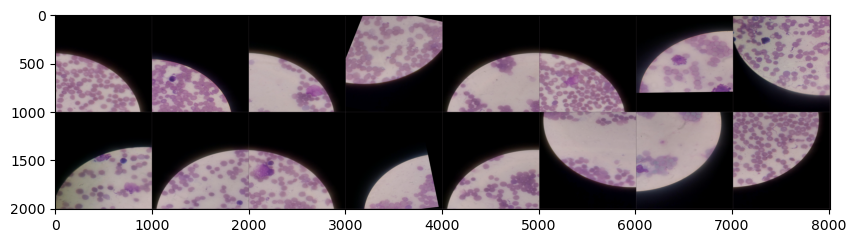

Labels: 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 1


In [10]:
### Check dataloaded image
def imshow(img):
    plt.figure(figsize=(10,10))
    img = img * torch.tensor([0.3400, 0.2943, 0.3148])[:, None, None] + torch.tensor([0.3165, 0.2706, 0.3013])[:, None, None]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(val_loader)
images, labels = next(dataiter) 

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print('Labels:', ' '.join(f'{labels[j].item()}' for j in range(images.shape[0])))



In [ ]:
### Training
model = NeuralNetwork().to(device)
criterion = nn.BCELoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=6,
    verbose=True,
    threshold=0.001,
    threshold_mode='rel'
)
num_epochs = 300
checkpoint_dir = '/home/chris/Documents/chagas/checkpoints/splitwb6'
log_file_path = os.path.join(checkpoint_dir, 'a_training_log.txt')

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

train_losses = []
val_losses = []

best_val_loss = float('inf') 

if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    model = nn.DataParallel(model)

first_model_saved = False 

# Train loop
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    total_train_loss = 0.0 

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1).type_as(outputs))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    average_train_loss = total_train_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).type_as(outputs))
            total_val_loss += loss.item()

    average_train_loss = total_train_loss / len(train_loader)
    average_val_loss = total_val_loss / len(val_loader)

    train_losses.append(average_train_loss)
    val_losses.append(average_val_loss)
    
    plt.figure()
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.ylim(0,1)    
    plt.savefig("loss.jpeg")
    plt.close()
    
    epoch_duration = (time.time() - start_time) / 60

    print(f"Epoch [{epoch+1}/{num_epochs}], Time: {epoch_duration:.2f} minutes, Average Train Loss: {average_train_loss:.4f}, Average Val Loss: {average_val_loss:.4f}")

    with open(log_file_path, 'a') as log_file:
        log_file.write(f"Epoch [{epoch+1}/{num_epochs}], Time: {epoch_duration:.2f} minutes, Average Train Loss: {average_train_loss:.4f}, Average Val Loss: {average_val_loss:.4f}\n")

    scheduler.step(average_val_loss)

    checkpoint = {
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_val_loss': best_val_loss
    }

    # Save first, best, last epoch
    if epoch == 0:
        first_model_path = os.path.join(checkpoint_dir, 'first_model_checkpoint.pth')
        torch.save(checkpoint, first_model_path)

    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        best_model_path = os.path.join(checkpoint_dir, 'best_model_checkpoint.pth')
        torch.save(checkpoint, best_model_path)

    recent_model_path = os.path.join(checkpoint_dir, 'recent_model_checkpoint.pth')
    torch.save(checkpoint, recent_model_path)
    
    #params = sum([p.flatten().size()[0] for p in list(model.parameters())])
    #print("Params: ",params)


In [ ]:
### Load checkpoint
def load_checkpoint(model, optimizer, filename):
    start_epoch = 0
    if os.path.isfile(filename):
        print("Loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("Loaded checkpoint '{}' (epoch {})".format(filename, checkpoint['epoch']))
    else:
        print("No checkpoint found at '{}'".format(filename))

    return model, optimizer, start_epoch

model = NeuralNetwork().to(device)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    model = nn.DataParallel(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

checkpoint_path = '/home/chris/Documents/chagas/checkpoints/splitwb5/recent_model_checkpoint.pth' 
model, optimizer, start_epoch = load_checkpoint(model, optimizer, checkpoint_path)

In [ ]:
### Continue training
criterion = nn.BCELoss()

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

additional_epochs = 200
total_epochs = start_epoch + additional_epochs

checkpoint_dir = '/home/chris/Documents/chagas/checkpoints/split7'
os.makedirs(checkpoint_dir, exist_ok=True)  
log_file_path = os.path.join(checkpoint_dir, 'a_training_log.txt')

train_losses = []
val_losses = []

for epoch in range(start_epoch, total_epochs):
    model.train()  
    total_train_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1).type_as(outputs))
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    average_train_loss = total_train_loss / len(train_loader)
    train_losses.append(average_train_loss)

    model.eval() 
    total_val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).type_as(outputs))
            total_val_loss += loss.item()

    average_val_loss = total_val_loss / len(val_loader)
    val_losses.append(average_val_loss)

    if scheduler is not None:
        scheduler.step(average_val_loss)

    epoch_duration = (time.time() - start_time) / 60

    print(f"Epoch {epoch+1}/{total_epochs}, Train Loss: {average_train_loss:.4f}, Val Loss: {average_val_loss:.4f}")

    with open(log_file_path, 'a') as log_file:
        log_file.write(f"Epoch [{epoch+1}/{num_epochs}], Time: {epoch_duration:.2f} minutes, Average Train Loss: {average_train_loss:.4f}, Average Val Loss: {average_val_loss:.4f}\n")

    recent_model_path = os.path.join(checkpoint_dir, f'recent_model_checkpoint_epoch_{epoch+1}.pth')
    torch.save(model.state_dict(), recent_model_path)

    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        best_model_path = os.path.join(checkpoint_dir, f'best_model_checkpoint_epoch_{epoch+1}.pth')
        torch.save(model.state_dict(), best_model_path)

Confusion Matrix:
 [[290  59]
 [ 66 280]]
Accuracy: 0.8201438848920863
Precision: 0.8259587020648967
Recall (True Positive Rate): 0.8092485549132948
F1 Score: 0.8175182481751826
Specificity (True Negative Rate): 0.830945558739255


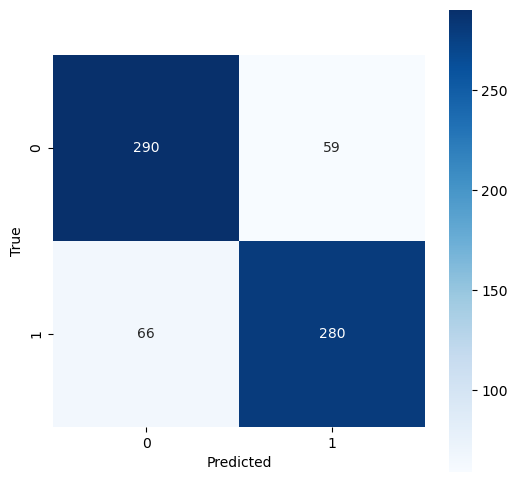

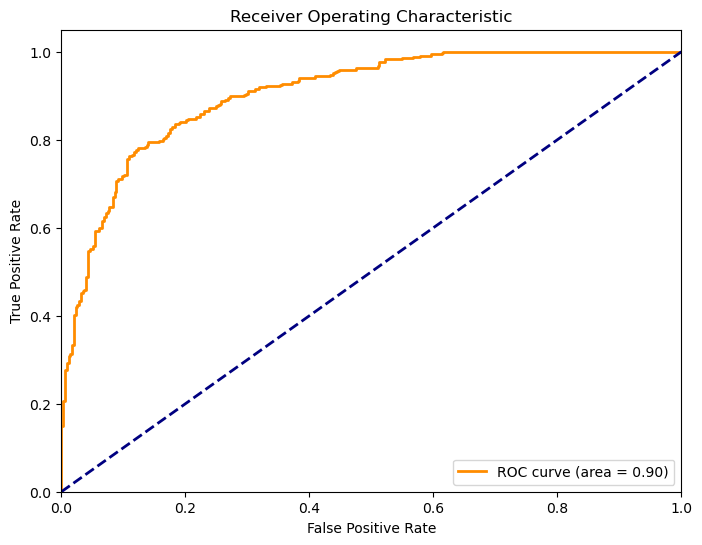

Area Under the ROC Curve (AUC): 0.90


In [9]:
### Evaluate
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

model.eval()

true_labels = []
predictions = []
prob_scores = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        probabilities = sigmoid(outputs.cpu().numpy()) 
        predicted = outputs.round().cpu().numpy()  

        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted)
        prob_scores.extend(probabilities.squeeze())  

true_labels = np.array(true_labels)
predictions = np.array(predictions)

cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:\n", cm)

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions) 
f1 = f1_score(true_labels, predictions)
TN, FP, FN, TP = cm.ravel()
specificity = TN / (TN + FP)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall (True Positive Rate):", recall)
print("F1 Score:", f1)
print("Specificity (True Negative Rate):", specificity)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC curve and AUC
roc_auc = roc_auc_score(true_labels, prob_scores)
fpr, tpr, thresholds = roc_curve(true_labels, prob_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f'Area Under the ROC Curve (AUC): {roc_auc:.2f}')

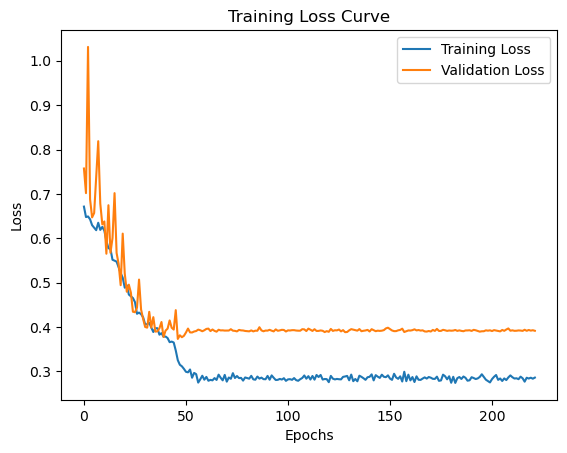

In [10]:
### Plot Losses
plt.plot(train_losses,label='Training Loss')
plt.plot(val_losses,label='Validation Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()